# Self-Driving Car Engineer Nanodegree

## Build a Traffic Sign Recognition Classifier by Deep Learning

---
## Step 0: Load The Data

In [1]:
import pickle

# Read the training, validation and testing data
training_file   = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file    = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

#Set the features and labels. 
#X_/y_train_o are original data, since they will be change in preprocessing step.
X_train_o, y_train_o = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

#Free up the memory
del(train)
del(valid)
del(test)

## Step 1: Data exploration 
First, I investigate some important statistics of the datasets. Then, I visulize one sample from each traffic sign to get an estimation of the quality of the images. Also, I look at the histogram of the data to have an idea about the distrubution of the labels.
- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.

In [2]:
import numpy as np

#Number of training examples
n_train = len(X_train_o)

#Number of validation examples
n_validation = len(X_valid)

#Number of testing examples.
n_test = len(X_test)

#The shape of an traffic sign image
image_shape = X_train_o.shape[1:]

#List of the unique labels
uniqueLabels = np.unique(y_train_o)
#Number of unique classes/labels
n_classes = len(uniqueLabels)

print("Number of training examples   =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples    =", n_test)
print("Image data shape  =", image_shape)
print("Number of classes =", n_classes)

Number of training examples   = 34799
Number of validation examples = 4410
Number of testing examples    = 12630
Image data shape  = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


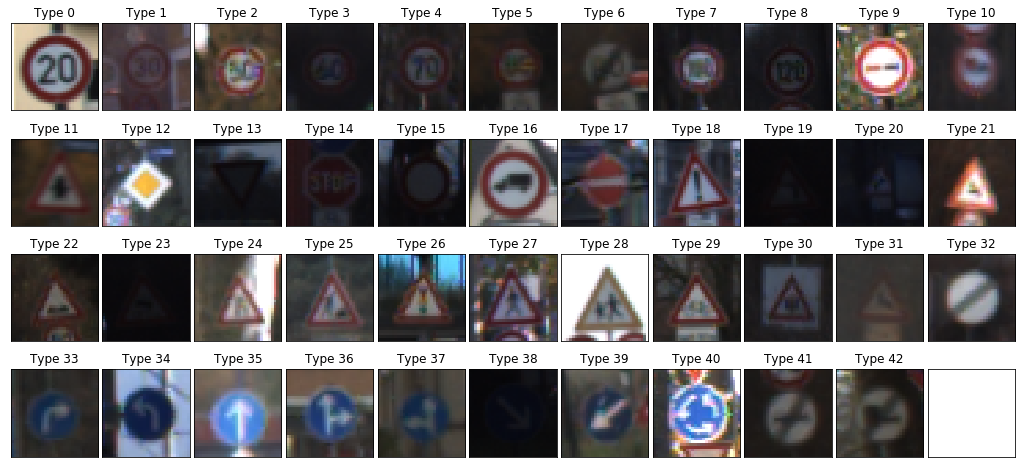

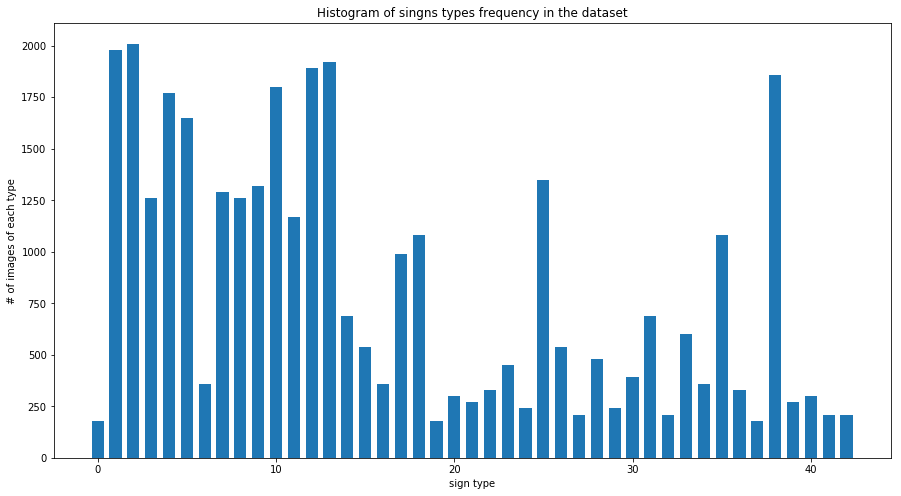

In [3]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

##Each pannel is a sample of one of the traffic signs type
#Set the plotting properties
fig, axes = plt.subplots(4, 11, figsize=(18, 8),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)
for ax, cls in zip(axes.flat, uniqueLabels):
    cls_index = np.where(y_train_o == cls)[0][0]
    ax.imshow(X_train_o[cls_index,:])
    ax.set_title('Type %s'%cls)
plt.show()


# Histogram of singns types frequency in the dataset
hist, bins = np.histogram(y_train_o, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = np.arange(0, 43)
fig = plt.subplots(1, figsize=(15, 8))
plt.bar(center, hist, align='center', width=width)
plt.xlabel('sign type')
plt.ylabel('# of images of each type')
plt.title('Histogram of singns types frequency in the dataset')
plt.show()


## Step 2: Data augmentation
I perform two data augmentation method to generalize the data and incease the training data size; namely:
- `'Central scaling'` to zoom in %80.
- `'Rotation'` to rotate the scaled and original images within [-20, 20] degree interval.


In [3]:
#Augmention
from math import pi
import cv2 
import matplotlib.pyplot as plt
import tensorflow as tf
try:
    import imutils
except:
    !pip install imutils
    !pip install --upgrade imutils
    import imutils

#This function scales the 32x32 images 80% and centally, by cropping 3 pixels from each edge.  
def central_scale80(image):
    return image[3:-3, 3:-3, :]

aug_imgs, aug_labels = [], []
sta_rot_ang = -20   #start rotate angle
end_rot_ang = 20    #begin rotate angle
n_rotation = 9      #number of rotations
#iteration angle
rot_step = (end_rot_ang - sta_rot_ang) / (n_rotation - 1)

for image, label in zip(X_train_o, y_train_o):
    #Scale images 
    scaled_img = central_scale80(image)
    for angle in np.arange(sta_rot_ang, end_rot_ang+1, rot_step):
        #Rotate the original image (Number of the outputs is n_rotation)
        #This rotation function does not crop the  
        rotated_o = imutils.rotate_bound(image, angle)
        #Rotate the scaled image (Number of the outputs is n_rotation)
        rotated_s = imutils.rotate_bound(scaled_img, angle)
        #Resize both above sets of images
        aug_imgs.append(cv2.resize(rotated_o, (32,32), interpolation = cv2.INTER_CUBIC))
        aug_imgs.append(cv2.resize(rotated_s, (32,32), interpolation = cv2.INTER_CUBIC))
        aug_labels.append(label)
        aug_labels.append(label)
aug_imgs = np.array(aug_imgs)
aug_labels = np.array(aug_labels)

print ("Size of the original training set (befor augmentation) =", len(y_train_o))
print ("Size of the new training set (after augmentation) =", len(aug_labels))


Size of the original training set (befor augmentation) = 34799
Size of the new training set (after augmentation) = 626382


## Step 3: Pre-Processing by grayscaling and normalization

For pre-peocessing, two method is performed; converting RGB images to gray scale, and normalizing the image array to be ranged within [-1, 1] interval instead of [0, 255].

In [4]:
#grayscaling and normalization
import cv2
#grayscaling function
def Gray(images):
    images_g = np.zeros(images.shape[:-1])
    for i in range(images.shape[0]):
        images_g[i,:] = cv2.cvtColor(images[i,:], cv2.COLOR_BGR2GRAY)

    return images_g

#normalization function
def Normalize(images):
    images_n = np.zeros(images.shape)
    for i in range(images.shape[0]):
        images_n[i,:] = cv2.normalize(images[i,:], None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
    return images_n

#grayscale
X_train_g = Gray(aug_imgs)
X_valid_g = Gray(X_valid)
X_test_g  = Gray(X_test)

#normalize
X_train_n = Normalize(X_train_g)
X_valid_n = Normalize(X_valid_g)
X_test_n = Normalize(X_test_g)

#Free up the memory
del(X_train_o)
del(y_train_o)
del(X_train_g)
del(X_valid_g)
del(X_test_g)

### Prepare data to be fed into Tensorflow functions

In [5]:
from sklearn.utils import shuffle
#Shuffle the training set to avoid any bias due to dara order
X_train, y_train = shuffle(X_train_n, aug_labels)
#Prepare the datasets shape fo be fed into tensorflow functions
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_valid = X_valid_n.reshape(X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1)
X_test = X_test_n.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

#Free up the memory
del(aug_imgs)
del(aug_labels)
del(X_train_n)
del(X_valid_n)
del(X_test_n)

### Define Tensorflow variables

In [6]:
import tensorflow as tf
EPOCHS = 100
BATCH_SIZE = 300
#Define features & labels variables
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Step 4: Modeling 

### Model Architecture

In [7]:
# Define LeNet architecture
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation
    conv1 = tf.nn.relu(conv1)

    # Pooling
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation
    conv2 = tf.nn.relu(conv2)

    # Pooling
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


### Train, Validate and Test the Model

The validation set is used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
# Training preperation 
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
# Calculate the accuracy on the training and validation set
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [9]:
# Train the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        if (i % 5 == 0): 
            saver.save(sess, './lenet', global_step=i)
            print("Model saved for epoch = ", i)
# Accuracy on the training and validation set
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


Training...

EPOCH 1 ...
Validation Accuracy = 0.939

Model saved for epoch =  0
EPOCH 2 ...
Validation Accuracy = 0.935

EPOCH 3 ...
Validation Accuracy = 0.951

EPOCH 4 ...
Validation Accuracy = 0.956

EPOCH 5 ...
Validation Accuracy = 0.957

EPOCH 6 ...
Validation Accuracy = 0.961

Model saved for epoch =  5
EPOCH 7 ...
Validation Accuracy = 0.968

EPOCH 8 ...
Validation Accuracy = 0.968

EPOCH 9 ...
Validation Accuracy = 0.965

EPOCH 10 ...
Validation Accuracy = 0.965

EPOCH 11 ...
Validation Accuracy = 0.967

Model saved for epoch =  10
EPOCH 12 ...
Validation Accuracy = 0.964

EPOCH 13 ...
Validation Accuracy = 0.962

EPOCH 14 ...
Validation Accuracy = 0.958

EPOCH 15 ...
Validation Accuracy = 0.968

EPOCH 16 ...
Validation Accuracy = 0.970

Model saved for epoch =  15
EPOCH 17 ...
Validation Accuracy = 0.967

EPOCH 18 ...
Validation Accuracy = 0.967

EPOCH 19 ...
Validation Accuracy = 0.959

EPOCH 20 ...
Validation Accuracy = 0.968

EPOCH 21 ...
Validation Accuracy = 0.968

Mode

---

## Step 5: Test a Model on New Images

Five images of German traffic signs is downloaded from the web, and their traffic sign types are predicted using the trained model.

### Load and Output the Images

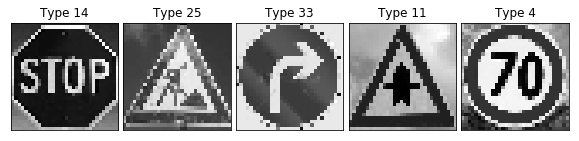

In [46]:
### Load, pre-process, and plot new images
import numpy as np
import cv2
import matplotlib.pyplot as plt

def load_prep():
    newImage = np.zeros((5, 32, 32))
    # these labels are extracted using the 'signnames.csv' file
    newLabel = [14, 25, 33, 11, 4]
    for i in range(5):
        img = cv2.imread("newImg/%s.png"%str(i+1))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.normalize(img, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        newImage[i,:] = cv2.resize(img, (32,32), interpolation = cv2.INTER_CUBIC)
    return newImage, newLabel

new_images , new_labels = load_prep()

fig, axes = plt.subplots(1,5, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)
for i, ax in enumerate(axes.flat):
    ax.imshow(new_images[i,:], cmap='gray')
    ax.set_title('Type %s'%new_labels[i])
plt.show()

new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2], 1)



### Accuracy and top 5 softmax probabilities of new images

In [52]:
softmax_logits = tf.nn.softmax(logits)
top_5 = tf.nn.top_k(softmax_logits, k=5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet-95.meta')
    saver.restore(sess, "./lenet-95")
    new_img_accuracy = evaluate(new_images, new_labels)
    print("New image set prediction accuracy = {:.2f} \n".format(new_img_accuracy))
    top_5_new_img = sess.run(top_5, feed_dict={x: new_images, keep_prob: 1.0})
    print ('Top 5 probabilities:')
    print (top_5_new_img)
    print ('\n whereas the correct labels read: ', new_labels)


New image set prediction accuracy = 0.80 

Top 5 probabilities:
TopKV2(values=array([[  9.99790251e-01,   2.09811056e-04,   9.88755744e-11,
          1.24509006e-11,   7.72891679e-13],
       [  1.00000000e+00,   2.30266005e-29,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   7.08951693e-32,   1.52217622e-34,
          0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[ 4,  1, 12,  2,  8],
       [25, 26,  0,  1,  2],
       [33,  0,  1,  2,  3],
       [11,  0,  1,  2,  3],
       [ 4,  1, 18,  0,  2]], dtype=int32))

 whereas the correct labels read:  [14, 25, 33, 11, 4]
